In [1]:
!mkdir dataset
!mkdir dataset/images
!mkdir dataset/labels
!mkdir dataset/images/train
!mkdir dataset/images/val
!mkdir dataset/labels/train
!mkdir dataset/labels/val

In [2]:
import os
images=os.listdir('/kaggle/input/lidc-idri-interpolated/train/images')
print(len(images))

14343


In [90]:
import numpy as np
from tqdm import tqdm
import shutil
from PIL import Image
import cv2
import os
import random
import matplotlib.pyplot as plt




def annotations(mask) :
    ans=[]
    num_labels, labels = cv2.connectedComponents(mask.astype(np.uint8))
    #print(num_labels, labels)
    for i in range(1, num_labels) :
        ys, xs = np.where(labels == i)
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        center_x=(max_x+min_x)//2
        center_y=(max_y+min_y)//2
        width=max_x-min_x
        height=max_y-min_y
        class_id=mask[ys[0], xs[0]]
        ans.append([class_id, [min_x, min_y, max_x, max_y], [center_x, center_y, width, height]])
    return ans

def is_intersecting(boxA, boxB):
    return not (
        boxA[2] <= boxB[0] or 
        boxA[0] >= boxB[2] or  
        boxA[3] <= boxB[1] or  
        boxA[1] >= boxB[3]     
    )


images=os.listdir('/kaggle/input/lidc-idri-interpolated/train/images')
bbox_width=60

train= np.empty((0, 961))
print(train.shape)

for i  in tqdm(range(len(images))) :
    img_path = '/kaggle/input/lidc-idri-interpolated/train/images/'+images[i]
    img = Image.open(img_path)
    img = np.array(img, dtype=np.uint8)
    mask_path = '/kaggle/input/lidc-idri-interpolated/train/masks/'+images[i]
    mask = Image.open(mask_path)
    mask = np.array(mask, dtype=np.uint8)
    anns=annotations(mask)
    if len(anns) :
        x=0
        y=0
        for x in range(0, 1100-bbox_width, 30) :
            for y in range(0, 1100-bbox_width, 30) :
                image=img[x:x+bbox_width, y:y+bbox_width]
                if np.max(image)==0 :
                    continue
                flag=0
                for ann in anns :
                    if is_intersecting([y, x, y+bbox_width, x+bbox_width], ann[1])>0.0 :
                        #print([x, y, x+bbox_width, y+bbox_width])
                        flag=1
                if flag :
                    continue

                if random.random()<0.008 :
                    hog = cv2.HOGDescriptor(_winSize=(bbox_width, bbox_width), _blockSize=(30, 30), _blockStride=(10, 10), _cellSize=(15, 15), _nbins=15)  
                    features = hog.compute(image)
                    features=np.append(features, 0)
                    #print(features.shape)
                    train = np.append(train, [features], axis=0) 
                    #print(train.shape)
        '''
        plt.imshow(img, cmap='gray')
        plt.title('Изображение')
        plt.show()


        plt.imshow(mask, cmap='gray')
        plt.title('Изображение')
        plt.show()
        #image=img[x:x+bbox_width, y:y+bbox_width]
        '''
        
        for ann in anns :
            class_id, bbox, coords=ann
            min_x, min_y, max_x, max_y=bbox
            center_x, center_y, width, height=coords
            image=img[center_y-bbox_width//2:center_y+bbox_width//2, center_x-bbox_width//2:center_x+bbox_width//2]
            '''
            plt.imshow(image, cmap='gray')
            plt.title('Изображение')
            plt.show()

            image=mask[center_y-bbox_width//2:center_y+bbox_width//2, center_x-bbox_width//2:center_x+bbox_width//2]
            plt.imshow(image, cmap='gray')
            plt.title('Изображение')
            plt.show()
            '''
            for b in range(5) :
                try :
                    dx = np.random.randint(-bbox_width//2+width//2, bbox_width//2-width//2)
                    dy = np.random.randint(-bbox_width//2+height//2, bbox_width//2-height//2)
                    image=img[center_y+dy-bbox_width//2:center_y+dy+bbox_width//2, center_x+dx-bbox_width//2:center_x+dx+bbox_width//2]
                    #image=mask[center_y+dy-bbox_width//2:center_y+dy+bbox_width//2, center_x+dx-bbox_width//2:center_x+dx+bbox_width//2]
                    if random.random()<0.5 :
                        image = cv2.flip(image, 1)
                    if random.random()<0.5 :
                        image = cv2.flip(image, 0)
                    hog = cv2.HOGDescriptor(_winSize=(bbox_width, bbox_width), _blockSize=(30, 30), _blockStride=(10, 10), _cellSize=(15, 15), _nbins=15)  
                    features = hog.compute(image)
                    features=np.append(features, class_id)
                    train = np.append(train, [features], axis=0) 
                except :
                    pass
        #break

(0, 961)


100%|██████████| 14343/14343 [20:17<00:00, 11.78it/s]


In [91]:
train.shape

(25447, 961)

In [92]:
train_x=train[:, :-1]
train_y=train[:, -1:]
print(train_x.shape)
print(train_y.shape)
vals, counts=np.unique(train_y, return_counts=True)
print(vals)
print(counts)

(25447, 960)
(25447, 1)
[0. 1. 2.]
[13292  4315  7840]


In [93]:
train_y=np.squeeze(train_y, axis=-1)
print(train_y.shape)

(25447,)


In [94]:
train_y = train_y.astype(np.int32) 
vals, counts=np.unique(train_y, return_counts=True)
print(vals)
print(counts)

[0 1 2]
[13292  4315  7840]


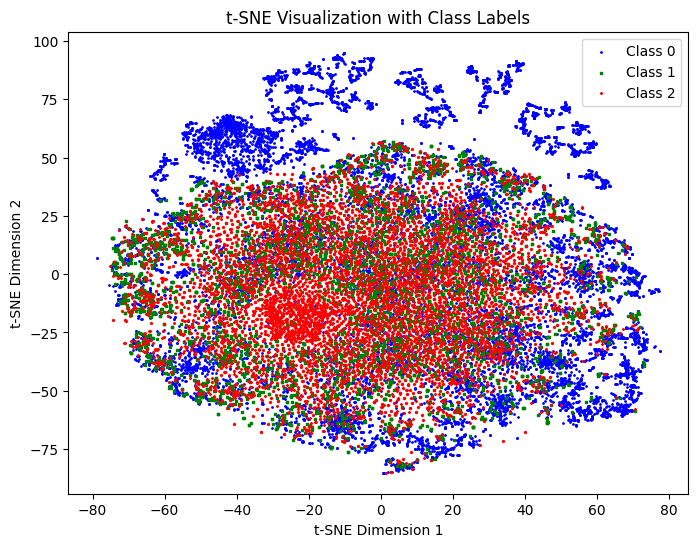

In [95]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_new = tsne.fit_transform(train_x)

plt.figure(figsize=(8, 6))

classes = set(train_y)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.75', 'pink', 'orange']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', 'x']
for i, cls in enumerate(classes):
    idx = train_y == cls
    plt.scatter(X_new[idx, 0], X_new[idx, 1], c=colors[i], s=1, marker=markers[i], label=f'Class {cls}')

plt.legend(loc='best')


plt.title('t-SNE Visualization with Class Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')


plt.show()

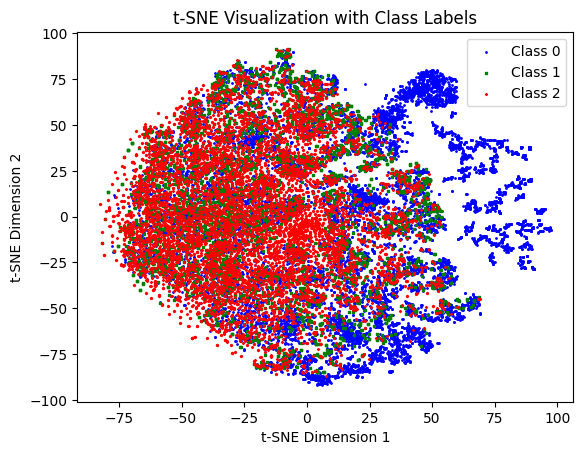

In [88]:
# hog = cv2.HOGDescriptor(_winSize=(bbox_width, bbox_width), _blockSize=(30, 30), _blockStride=(10, 10), _cellSize=(30, 30), _nbins=9) 
for i, cls in enumerate(classes):
    idx = train_y == cls
    plt.scatter(X_new[idx, 0], X_new[idx, 1], c=colors[i], s=1, marker=markers[i], label=f'Class {cls}')

plt.legend(loc='best')


plt.title('t-SNE Visualization with Class Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')


plt.show()

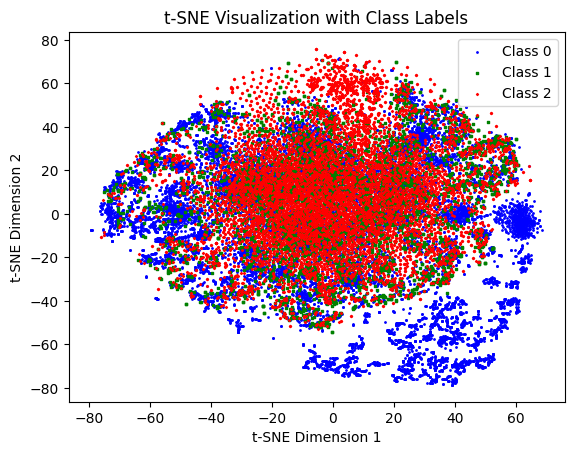

In [80]:
for i, cls in enumerate(classes):
    idx = train_y == cls
    plt.scatter(X_new[idx, 0], X_new[idx, 1], c=colors[i], s=1, marker=markers[i], label=f'Class {cls}')

plt.legend(loc='best')


plt.title('t-SNE Visualization with Class Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')


plt.show()
#bbox_width=60
#hog = cv2.HOGDescriptor(_winSize=(bbox_width, bbox_width), _blockSize=(20, 20), _blockStride=(10, 10), _cellSize=(5, 5), _nbins=9)

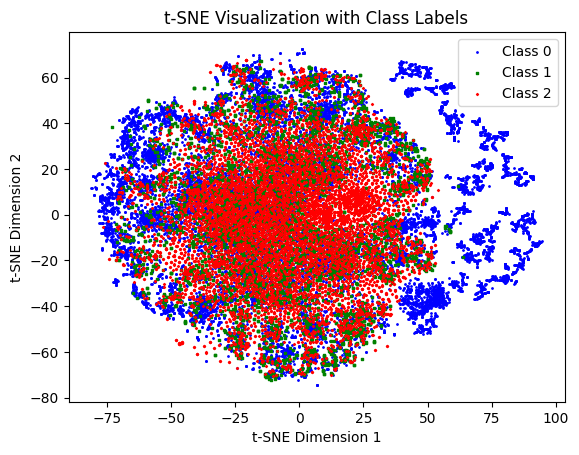

In [71]:
for i, cls in enumerate(classes):
    idx = train_y == cls
    plt.scatter(X_new[idx, 0], X_new[idx, 1], c=colors[i], s=1, marker=markers[i], label=f'Class {cls}')

plt.legend(loc='best')


plt.title('t-SNE Visualization with Class Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')


plt.show()
#bbox_width=60
#hog = cv2.HOGDescriptor(_winSize=(bbox_width, bbox_width), _blockSize=(20, 20), _blockStride=(10, 10), _cellSize=(10, 10), _nbins=9)

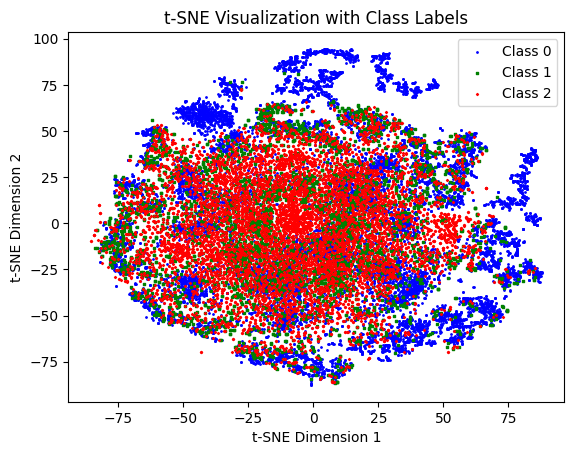

In [59]:
for i, cls in enumerate(classes):
    idx = train_y == cls
    plt.scatter(X_new[idx, 0], X_new[idx, 1], c=colors[i],s=1,  marker=markers[i], label=f'Class {cls}')

plt.legend(loc='best')


plt.title('t-SNE Visualization with Class Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')


plt.show()
#bbox_width=60
#hog = cv2.HOGDescriptor(_winSize=(bbox_width, bbox_width), _blockSize=(bbox_width, bbox_width), _blockStride=(10, 10), _cellSize=(10, 10), _nbins=9)